In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
from jax import random


In [4]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [5]:
train = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)
train.head()

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker

In [6]:
train.describe()

Weeks          FVC      Percent          Age
count  1549.000000  1549.000000  1549.000000  1549.000000
mean     31.861846  2690.479019    77.672654    67.188509
std      23.247550   832.770959    19.823261     7.057395
min      -5.000000   827.000000    28.877577    49.000000
25%      12.000000  2109.000000    62.832700    63.000000
50%      28.000000  2641.000000    75.676937    68.000000
75%      47.000000  3171.000000    88.621065    72.000000
max     133.000000  6399.000000   153.145378    88.000000

In [7]:
# Number of unique patients
train['Patient'].nunique()

176

<Axes: ylabel='Frequency'>

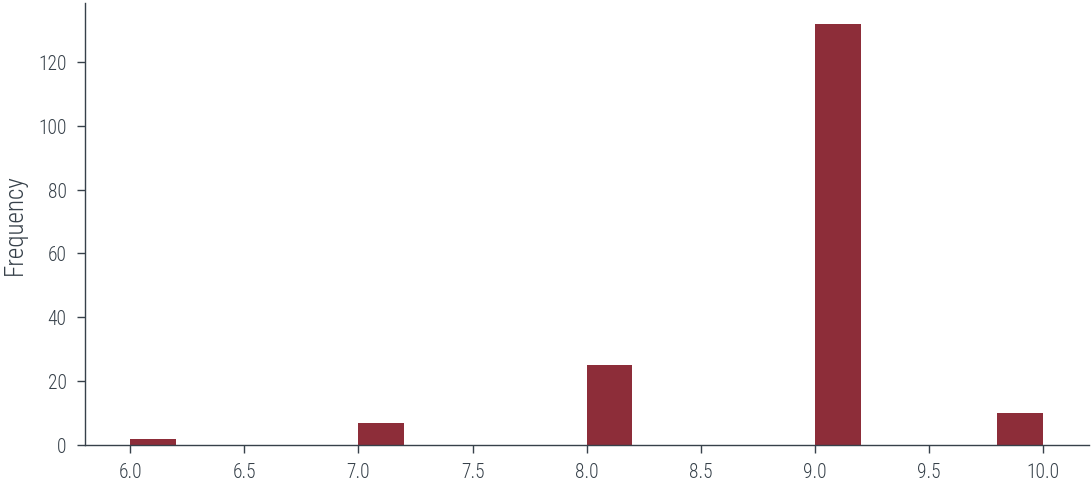

In [8]:
#Number of records per patient
train['Patient'].value_counts().plot(kind='hist', bins=20)

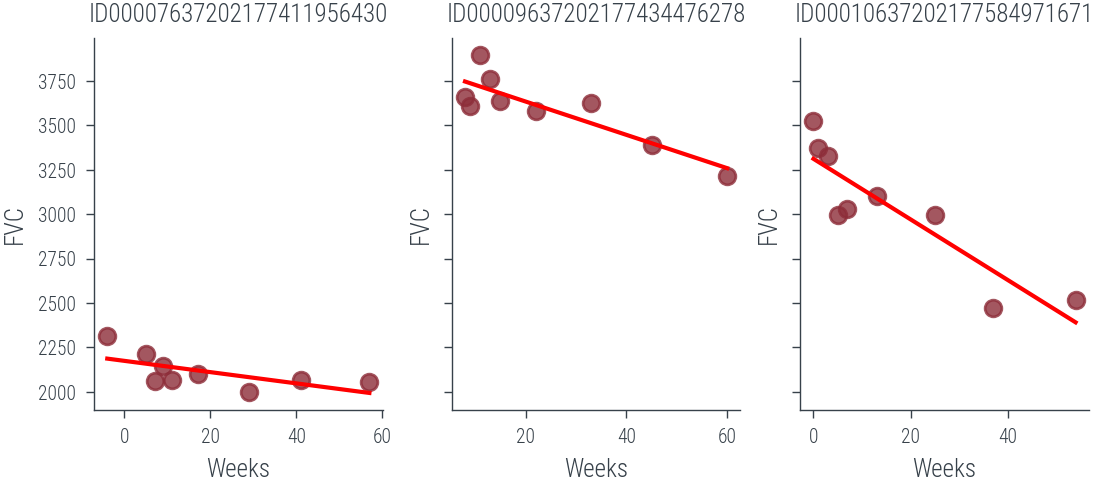

In [9]:
def chart_patient(patient_id, ax):
    data = train[train["Patient"] == patient_id]
    x = data["Weeks"]
    y = data["FVC"]
    ax.set_title(patient_id)
    sns.regplot(x=x, y=y, ax=ax, ci=None, line_kws={"color": "red"})


f, axes = plt.subplots(1, 3, sharey=True)
chart_patient("ID00007637202177411956430", axes[0])
chart_patient("ID00009637202177434476278", axes[1])
chart_patient("ID00010637202177584971671", axes[2])

In [10]:
try:
    import numpyro
except ImportError:
    %pip install numpyro
    import numpyro

  Obtaining dependency information for numpyro from https://files.pythonhosted.org/packages/f9/e1/545f037aa1d119d83bebb6816d9e01138bb2a2ee5878cdd1c1e76fe3a239/numpyro-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for multipledispatch from https://files.pythonhosted.org/packages/51/c0/00c9809d8b9346eb238a6bbd5f83e846a4ce4503da94a4c08cb7284c325b/multipledispatch-1.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for tqdm from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 20.0 MB/s eta 0:00:00
Using cached numpyro-0.13.2-py3-none-any.whl (312 kB)
Using cached multipledispatch-1.0.0-py3-none-any.whl (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


/home/nipun.batra/miniforge3/envs/nipun-jaxenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import numpyro.distributions as dist

### Pooled model

$\alpha \sim \text{Normal}(0, 1)$

$\beta \sim \text{Normal}(0, 1)$

$\sigma \sim \text{HalfNormal}(100)$

$FVC_i \sim \text{Normal}(\alpha + \beta \cdot Week_i, \sigma)$



In [14]:
# Convert NumPy arrays to numpy tensors
sample_weeks = train["Weeks"].values
fvc = train["FVC"].values

In [15]:
### Linear regression from scikit-learn
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(sample_weeks.reshape(-1, 1), fvc)

LinearRegression()

In [16]:
all_weeks = np.arange(-12, 134, 1)

Text(0, 0.5, 'FVC')

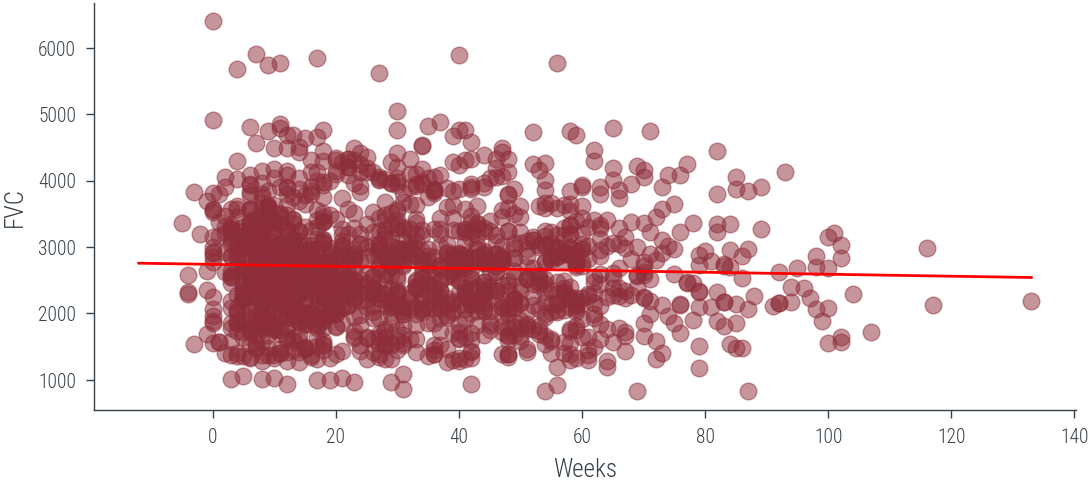

In [17]:
# Plot the data and the regression line
plt.scatter(sample_weeks, fvc, alpha=0.5)
plt.plot(all_weeks, lr.predict(all_weeks.reshape(-1, 1)), color="red")
plt.xlabel("Weeks")
plt.ylabel("FVC")

In [18]:
lr.coef_, lr.intercept_

(array([-1.48471319]), 2737.784722381955)

In [19]:
def pooled_model(sample_weeks, fvc):
    a = numpyro.sample("a", dist.Normal(0., 500.))
    b = numpyro.sample("b", dist.Normal(0., 500.))
    sigma = numpyro.sample("sigma", dist.HalfNormal(50.))
    with numpyro.plate("samples", len(sample_weeks)):
        fvc = numpyro.sample("fvc", dist.Normal(a + b * sample_weeks, sigma), obs=fvc)
    return fvc

In [20]:
sample_weeks.shape

(1549,)

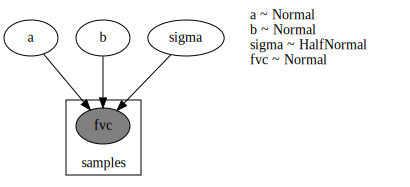

In [22]:
# Render the model graph
data = (train["Weeks"].values, train["FVC"].values)
numpyro.render_model(pooled_model, model_kwargs={"sample_weeks": sample_weeks, "fvc": fvc}, 
                render_distributions=True,
                render_params=True,
                )

In [23]:
from sklearn.preprocessing import LabelEncoder

patient_encoder = LabelEncoder()
train["patient_code"] = patient_encoder.fit_transform(train["Patient"].values)

In [24]:
patient_code = train["patient_code"].values

In [25]:
from numpyro.infer import MCMC, NUTS, Predictive

In [26]:

nuts_kernel = NUTS(pooled_model)

mcmc = MCMC(nuts_kernel, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)


In [27]:
mcmc.run(rng_key, sample_weeks=sample_weeks, fvc=fvc)

posterior_samples = mcmc.get_samples()

sample: 100%|██████████| 4000/4000 [00:17<00:00, 222.38it/s, 3 steps of size 4.68e-01. acc. prob=0.91] 


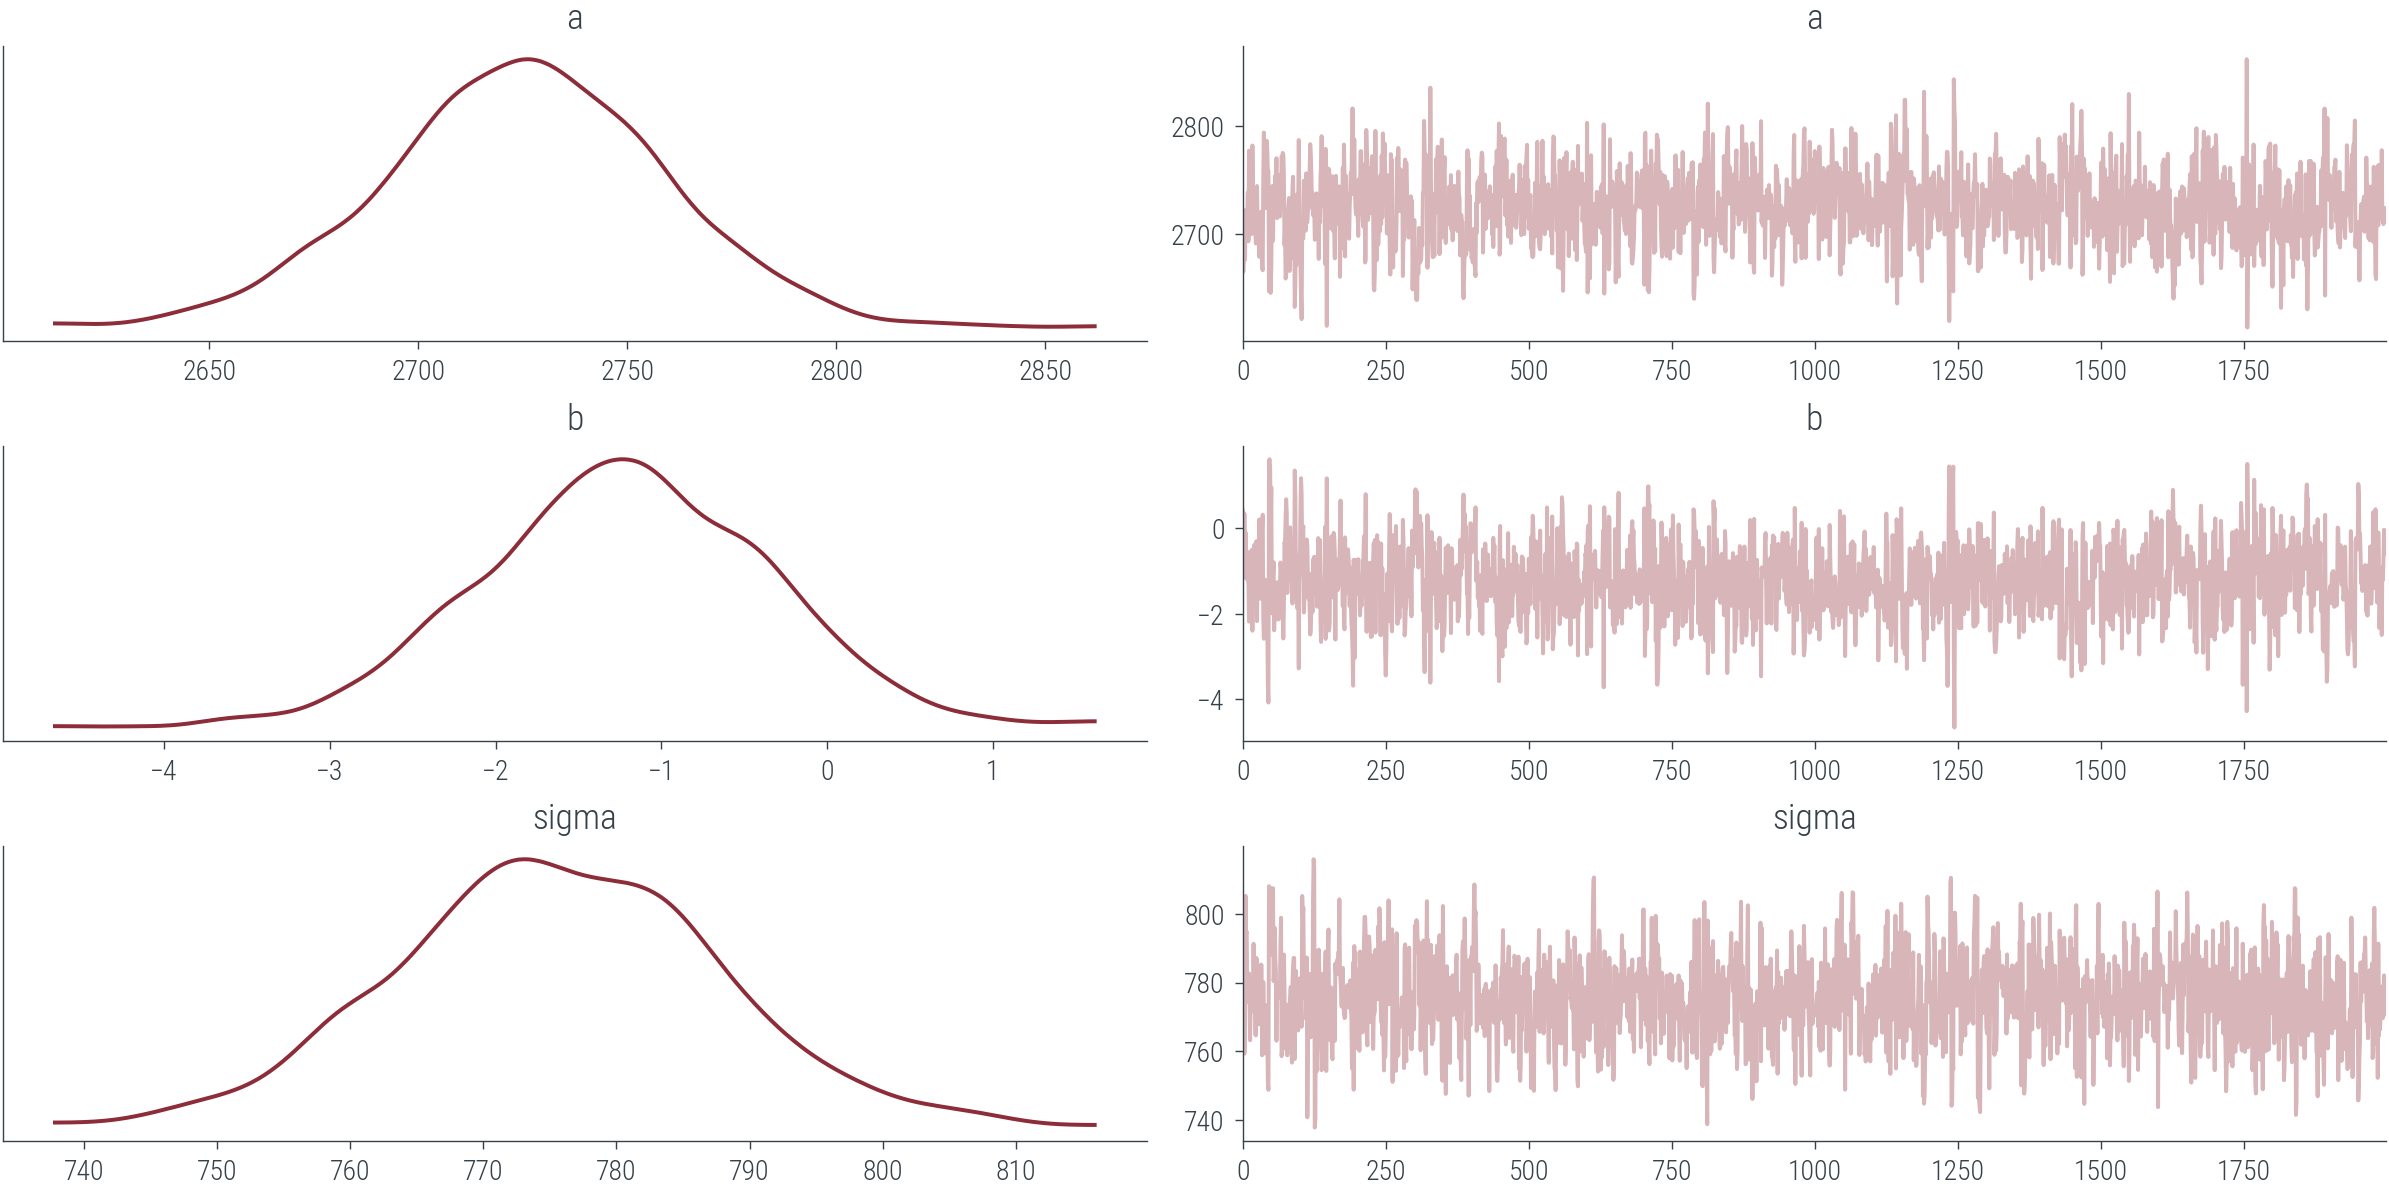

In [28]:
import arviz as az

data = az.from_numpyro(mcmc)
az.plot_trace(data, compact=True);

In [30]:
# Summary statistics
az.summary(data, round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a      2725.23  33.55  2667.68  2793.97       1.12     0.79    891.56   
b        -1.22   0.87    -2.73     0.50       0.03     0.02    926.57   
sigma   775.45  12.17   754.03   799.53       0.37     0.26   1106.89   

       ess_tail  r_hat  
a        956.30    NaN  
b       1071.58    NaN  
sigma   1155.64    NaN

In [31]:
# Predictive distribution
predictive = Predictive(pooled_model, mcmc.get_samples())


In [32]:
predictive

In [33]:
# Predictive distribution
#predictive = Predictive(pooled_model, num_samples=2000)

In [35]:
predictions = predictive(rng_key, all_weeks, None)

<Axes: >

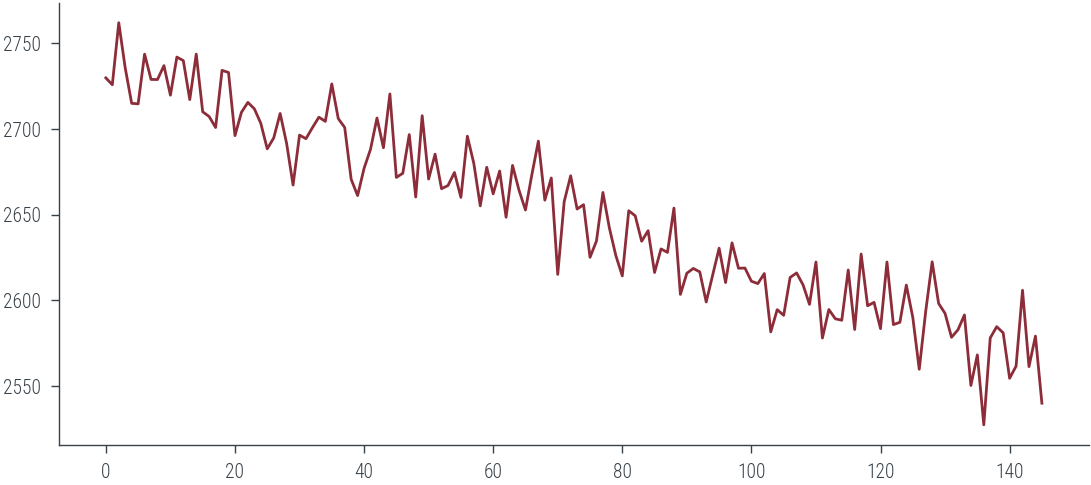

In [36]:
pd.DataFrame(predictions["fvc"]).mean().plot()

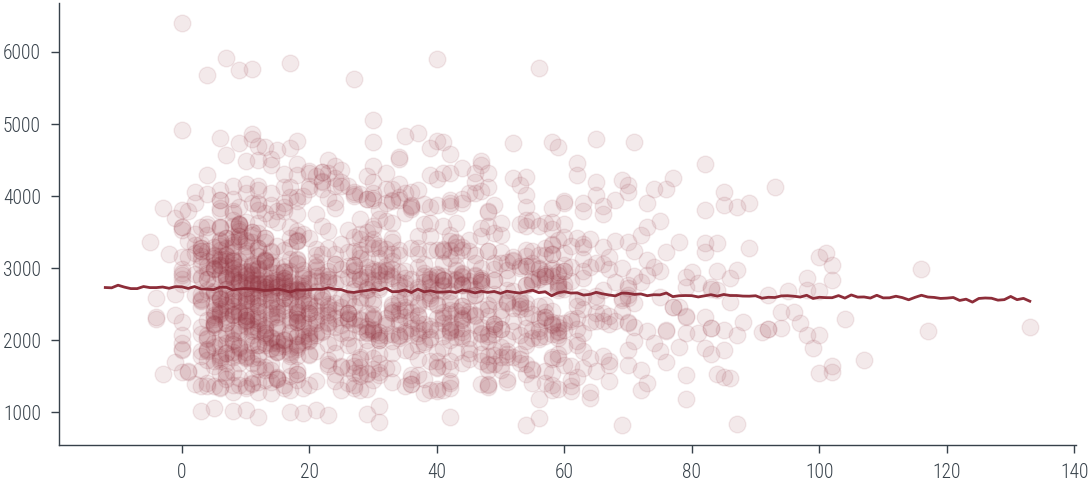

In [38]:
plt.plot(all_weeks, predictions["fvc"].mean(axis=0))
plt.scatter(sample_weeks, fvc, alpha=0.1)

Text(0, 0.5, 'FVC')

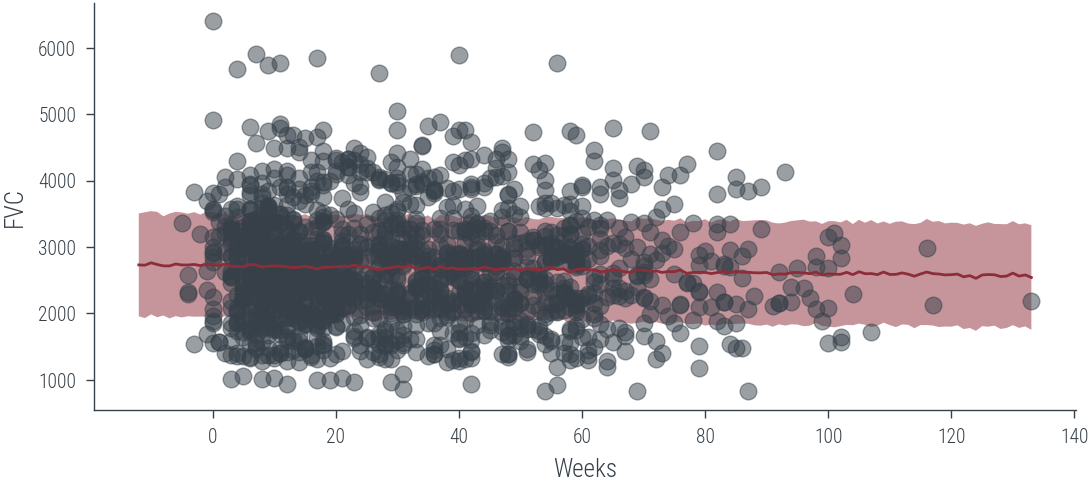

In [39]:
# Get the mean and standard deviation of the predictions
mu = predictions["fvc"].mean(axis=0)
sigma = predictions["fvc"].std(axis=0)

# Plot the predictions
plt.plot(all_weeks, mu)
plt.fill_between(all_weeks, mu - sigma, mu + sigma, alpha=0.5)
plt.scatter(sample_weeks, fvc, alpha=0.5)
plt.xlabel("Weeks")
plt.ylabel("FVC")

In [50]:
# Unpooled model
def unpool_model(sample_weeks, patient_code, fvc=None):
    sigma = numpyro.sample("sigma", dist.HalfNormal(20.))
    with numpyro.plate("patients", patient_code.max() + 1):
        a_p = numpyro.sample("a_p", dist.Normal(0, 500.))
        b_p = numpyro.sample("b_p", dist.Normal(0, 500.))
    with numpyro.plate("samples", len(sample_weeks)):
        fvc = numpyro.sample("fvc", numpyro.distributions.Normal(a_p[patient_code] + b_p[patient_code] * sample_weeks, sigma), obs=fvc)
    return fvc

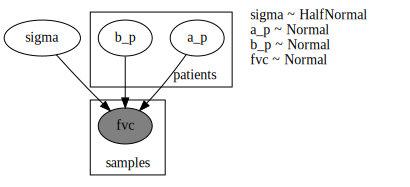

In [51]:
# Render the model graph
data = (train["Weeks"].values, 
        train["patient_code"].values, 
        train["FVC"].values)
# torchify the data
numpyro.render_model(unpool_model, model_args=data, 
                render_distributions=True,
                render_params=True,
                )

In [52]:
nuts_kernel_unpooled = NUTS(unpool_model)

mcmc_unpooled = MCMC(nuts_kernel_unpooled, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)


In [53]:
data

(array([-4,  5,  7, ..., 31, 43, 59]),
 array([  0,   0,   0, ..., 175, 175, 175]),
 array([2315, 2214, 2061, ..., 2908, 2975, 2774]))

In [54]:
mcmc_unpooled.run(rng_key, *data)

posterior_samples = mcmc_unpooled.get_samples()

sample: 100%|██████████| 4000/4000 [02:21<00:00, 28.27it/s, 63 steps of size 1.03e-01. acc. prob=0.87] 


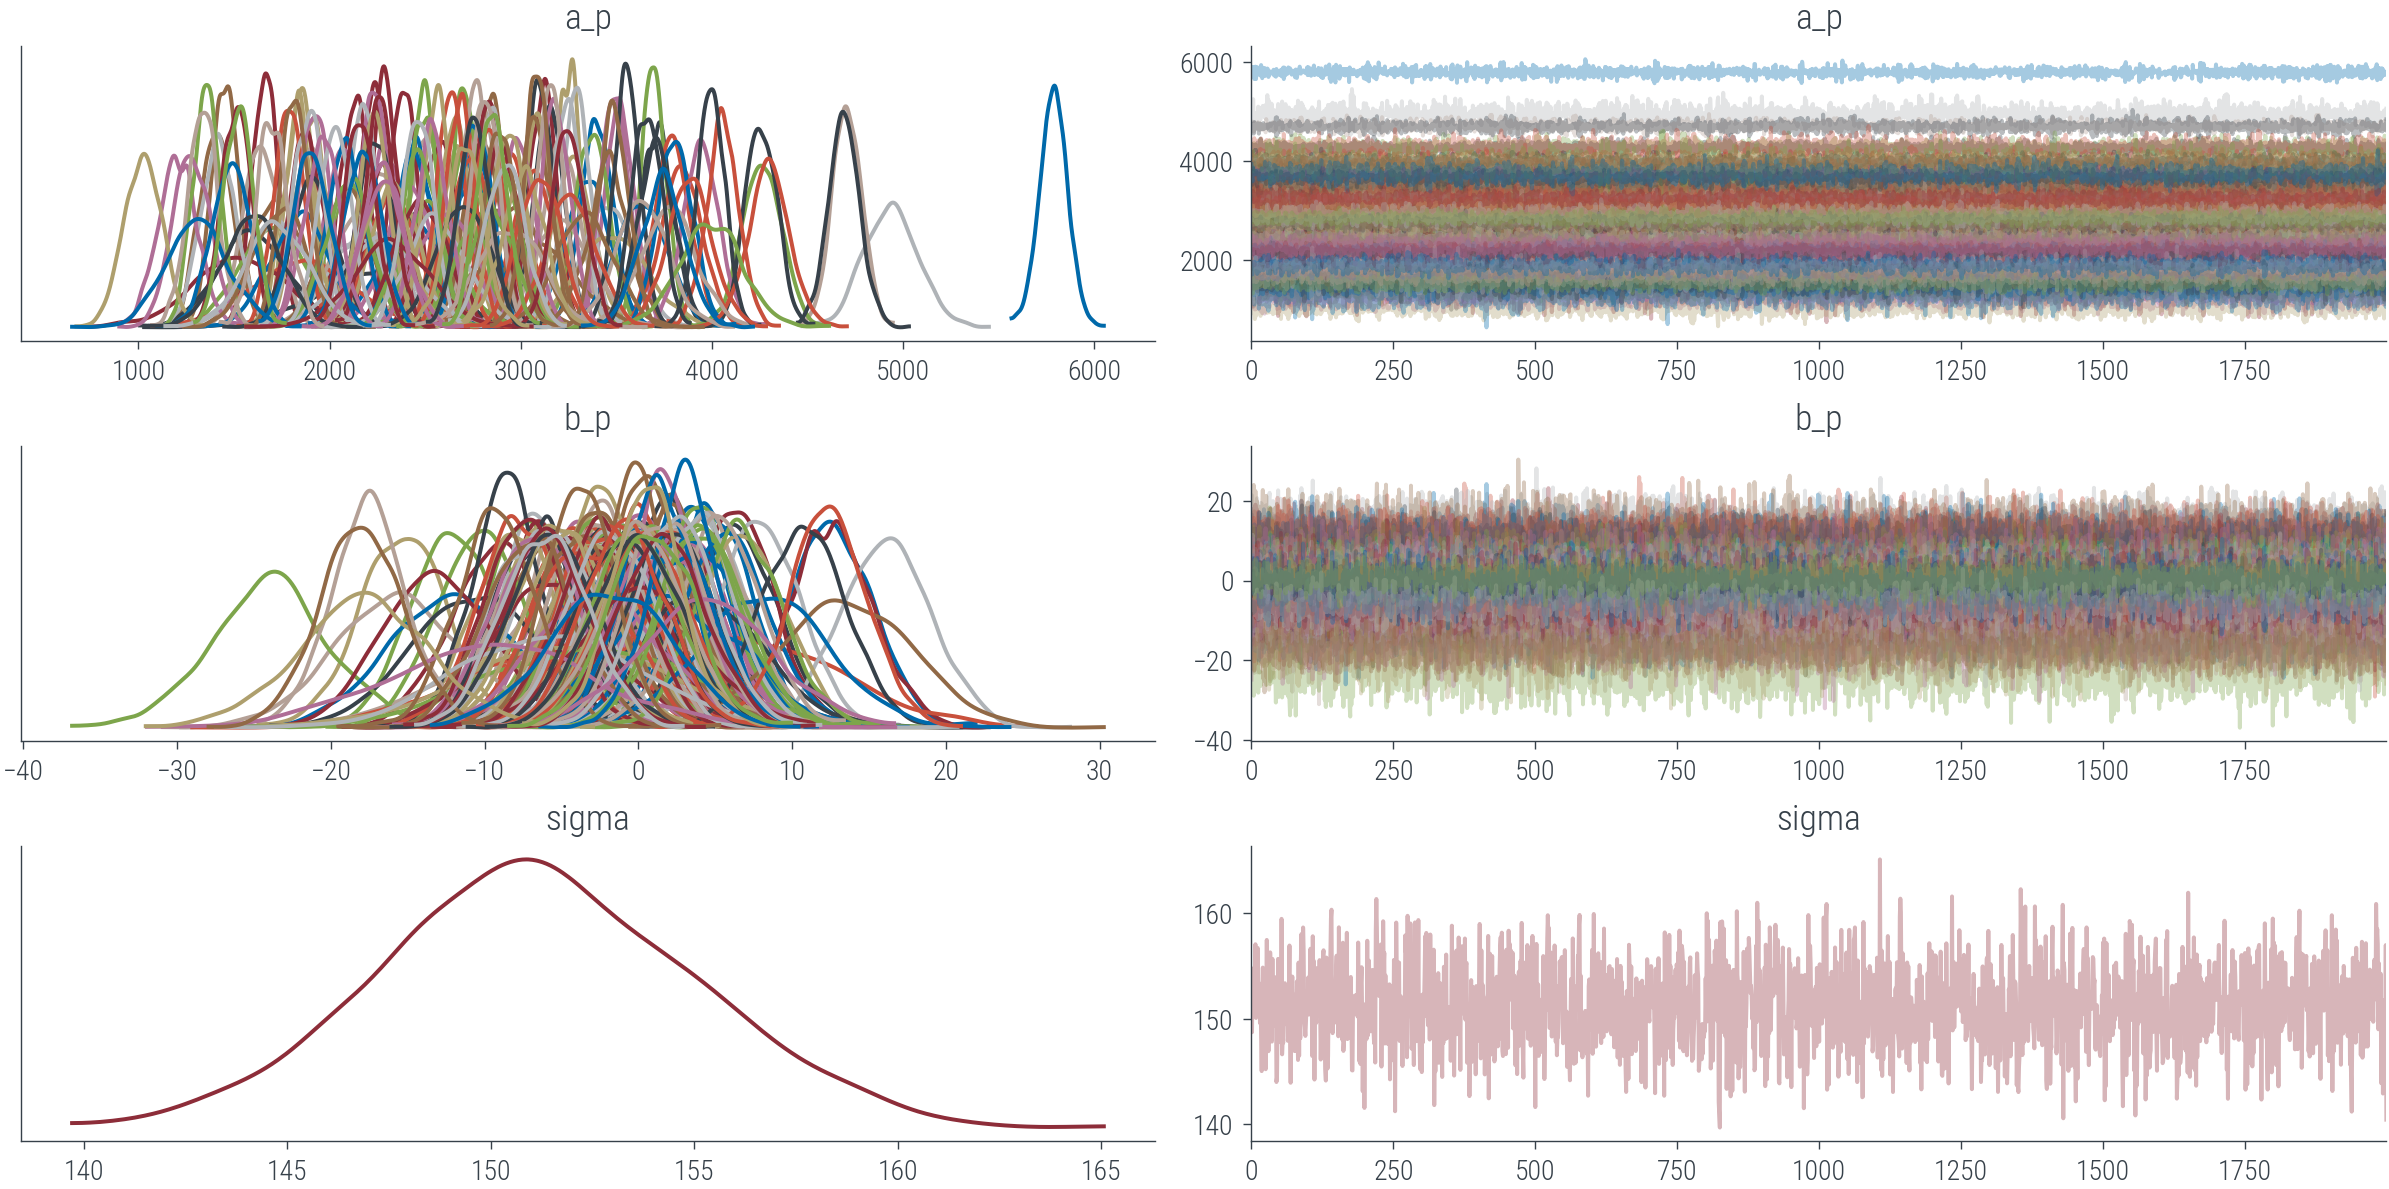

In [57]:
az.plot_trace(az.from_numpyro(mcmc_unpooled), compact=True);

In [58]:
# Predictive distribution for unpooled model

predictive_unpooled = Predictive(unpool_model, mcmc_unpooled.get_samples())


/home/nipun.batra/miniforge3/envs/nipun-jaxenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nipun.batra/miniforge3/envs/nipun-jaxenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


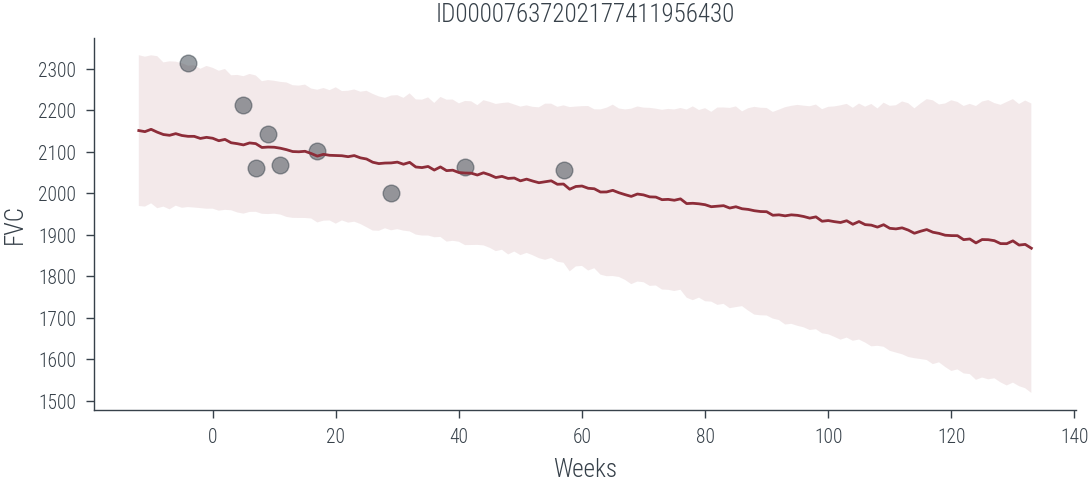

In [69]:
# Predictive distribution for unpooled model for all weeks for a given patient

all_weeks = np.arange(-12, 134, 1)
def predict_unpooled(patient_code):
    predictions = predictive_unpooled(rng_key, all_weeks, patient_code)
    mu = predictions["fvc"].mean(axis=0)
    sigma = predictions["fvc"].std(axis=0)
    return mu, sigma

# Plot the predictions for a given patient
def plot_patient(patient_code):
    mu, sigma = predict_unpooled(patient_code)
    plt.plot(all_weeks, mu)
    plt.fill_between(all_weeks, mu - sigma, mu + sigma, alpha=0.1)
    id_to_patient = patient_encoder.inverse_transform([patient_code])[0]
    #print(id_to_patient[0], patient_code)
    #print(patient_code, id_to_patient)
    patient_weeks = train[train["Patient"] == id_to_patient]["Weeks"]
    patient_fvc = train[train["Patient"] == id_to_patient]["FVC"]
    plt.scatter(patient_weeks, patient_fvc, alpha=0.5)
    #plt.scatter(sample_weeks[train["patient_code"] == patient_code.item()], fvc[train["patient_code"] == patient_code.item()], alpha=0.5)
    plt.xlabel("Weeks")
    plt.ylabel("FVC")
    plt.title(patient_encoder.inverse_transform([patient_code])[0])

plot_patient(np.array([0]))

[1] ID00009637202177434476278


/home/nipun.batra/miniforge3/envs/nipun-jaxenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nipun.batra/miniforge3/envs/nipun-jaxenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


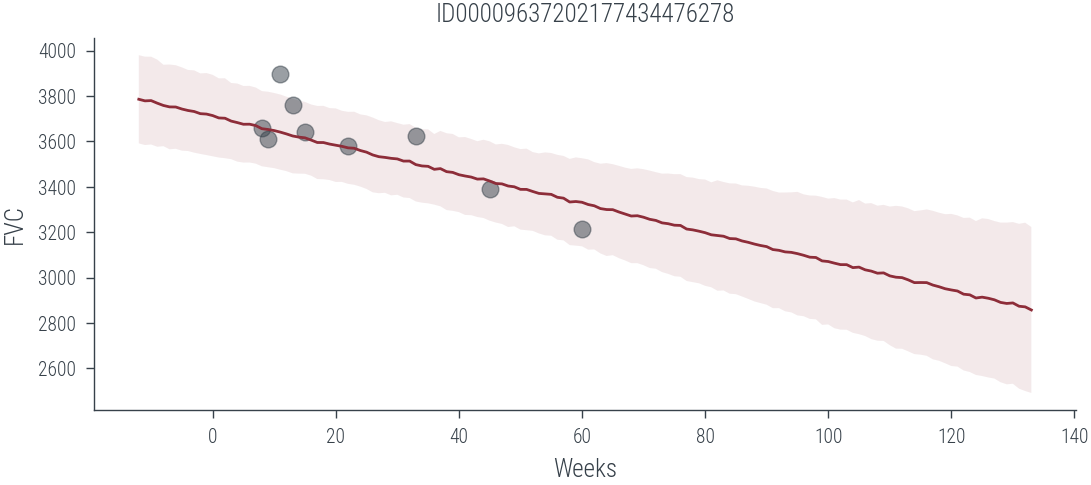

In [68]:
plot_patient(np.array([1]))

/home/nipun.batra/miniforge3/envs/nipun-jaxenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nipun.batra/miniforge3/envs/nipun-jaxenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


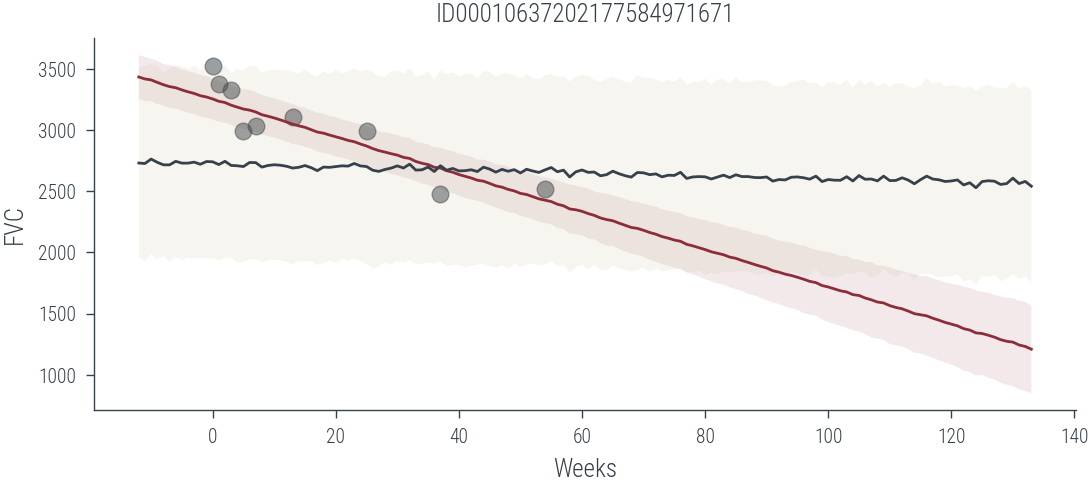

In [74]:
plot_patient(np.array([2]))
# Plot from pooled model
plt.plot(all_weeks, predictions["fvc"].mean(axis=0), label="Pooled")
plt.fill_between(all_weeks, predictions["fvc"].mean(axis=0) - predictions["fvc"].std(axis=0), predictions["fvc"].mean(axis=0) + predictions["fvc"].std(axis=0), alpha=0.1)


In [75]:
### Hierarchical model

def final_model(patient_code, Weeks, FVC_obs=None):
    μ_α = numpyro.sample("μ_α", dist.Normal(0.0, 500.0))
    σ_α = numpyro.sample("σ_α", dist.HalfNormal(100.0))
    μ_β = numpyro.sample("μ_β", dist.Normal(0.0, 3.0))
    σ_β = numpyro.sample("σ_β", dist.HalfNormal(3.0))

    n_patients = len(np.unique(patient_code))

    with numpyro.plate("plate_i", n_patients):
        α = numpyro.sample("α", dist.Normal(μ_α, σ_α))
        β = numpyro.sample("β", dist.Normal(μ_β, σ_β))

    σ = numpyro.sample("σ", dist.HalfNormal(100.0))
    FVC_est = α[patient_code] + β[patient_code] * Weeks

    with numpyro.plate("data", len(patient_code)):
        numpyro.sample("obs", dist.Normal(FVC_est, σ), obs=FVC_obs)    

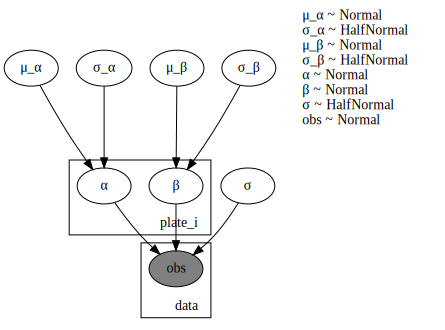

In [76]:
# Render the model graph


numpyro.render_model(final_model, model_args=data,
                render_distributions=True,
                render_params=True,
                )


In [77]:
nuts_final = NUTS(final_model)

mcmc_final = MCMC(nuts_final, num_samples=2000, num_warmup=2000)
rng_key = random.PRNGKey(0)


In [78]:
mcmc_final.run(rng_key, *data)

sample: 100%|██████████| 4000/4000 [04:00<00:00, 16.65it/s, 127 steps of size 3.36e-02. acc. prob=0.79] 


In [79]:
predictive_final = Predictive(final_model, mcmc_final.get_samples())


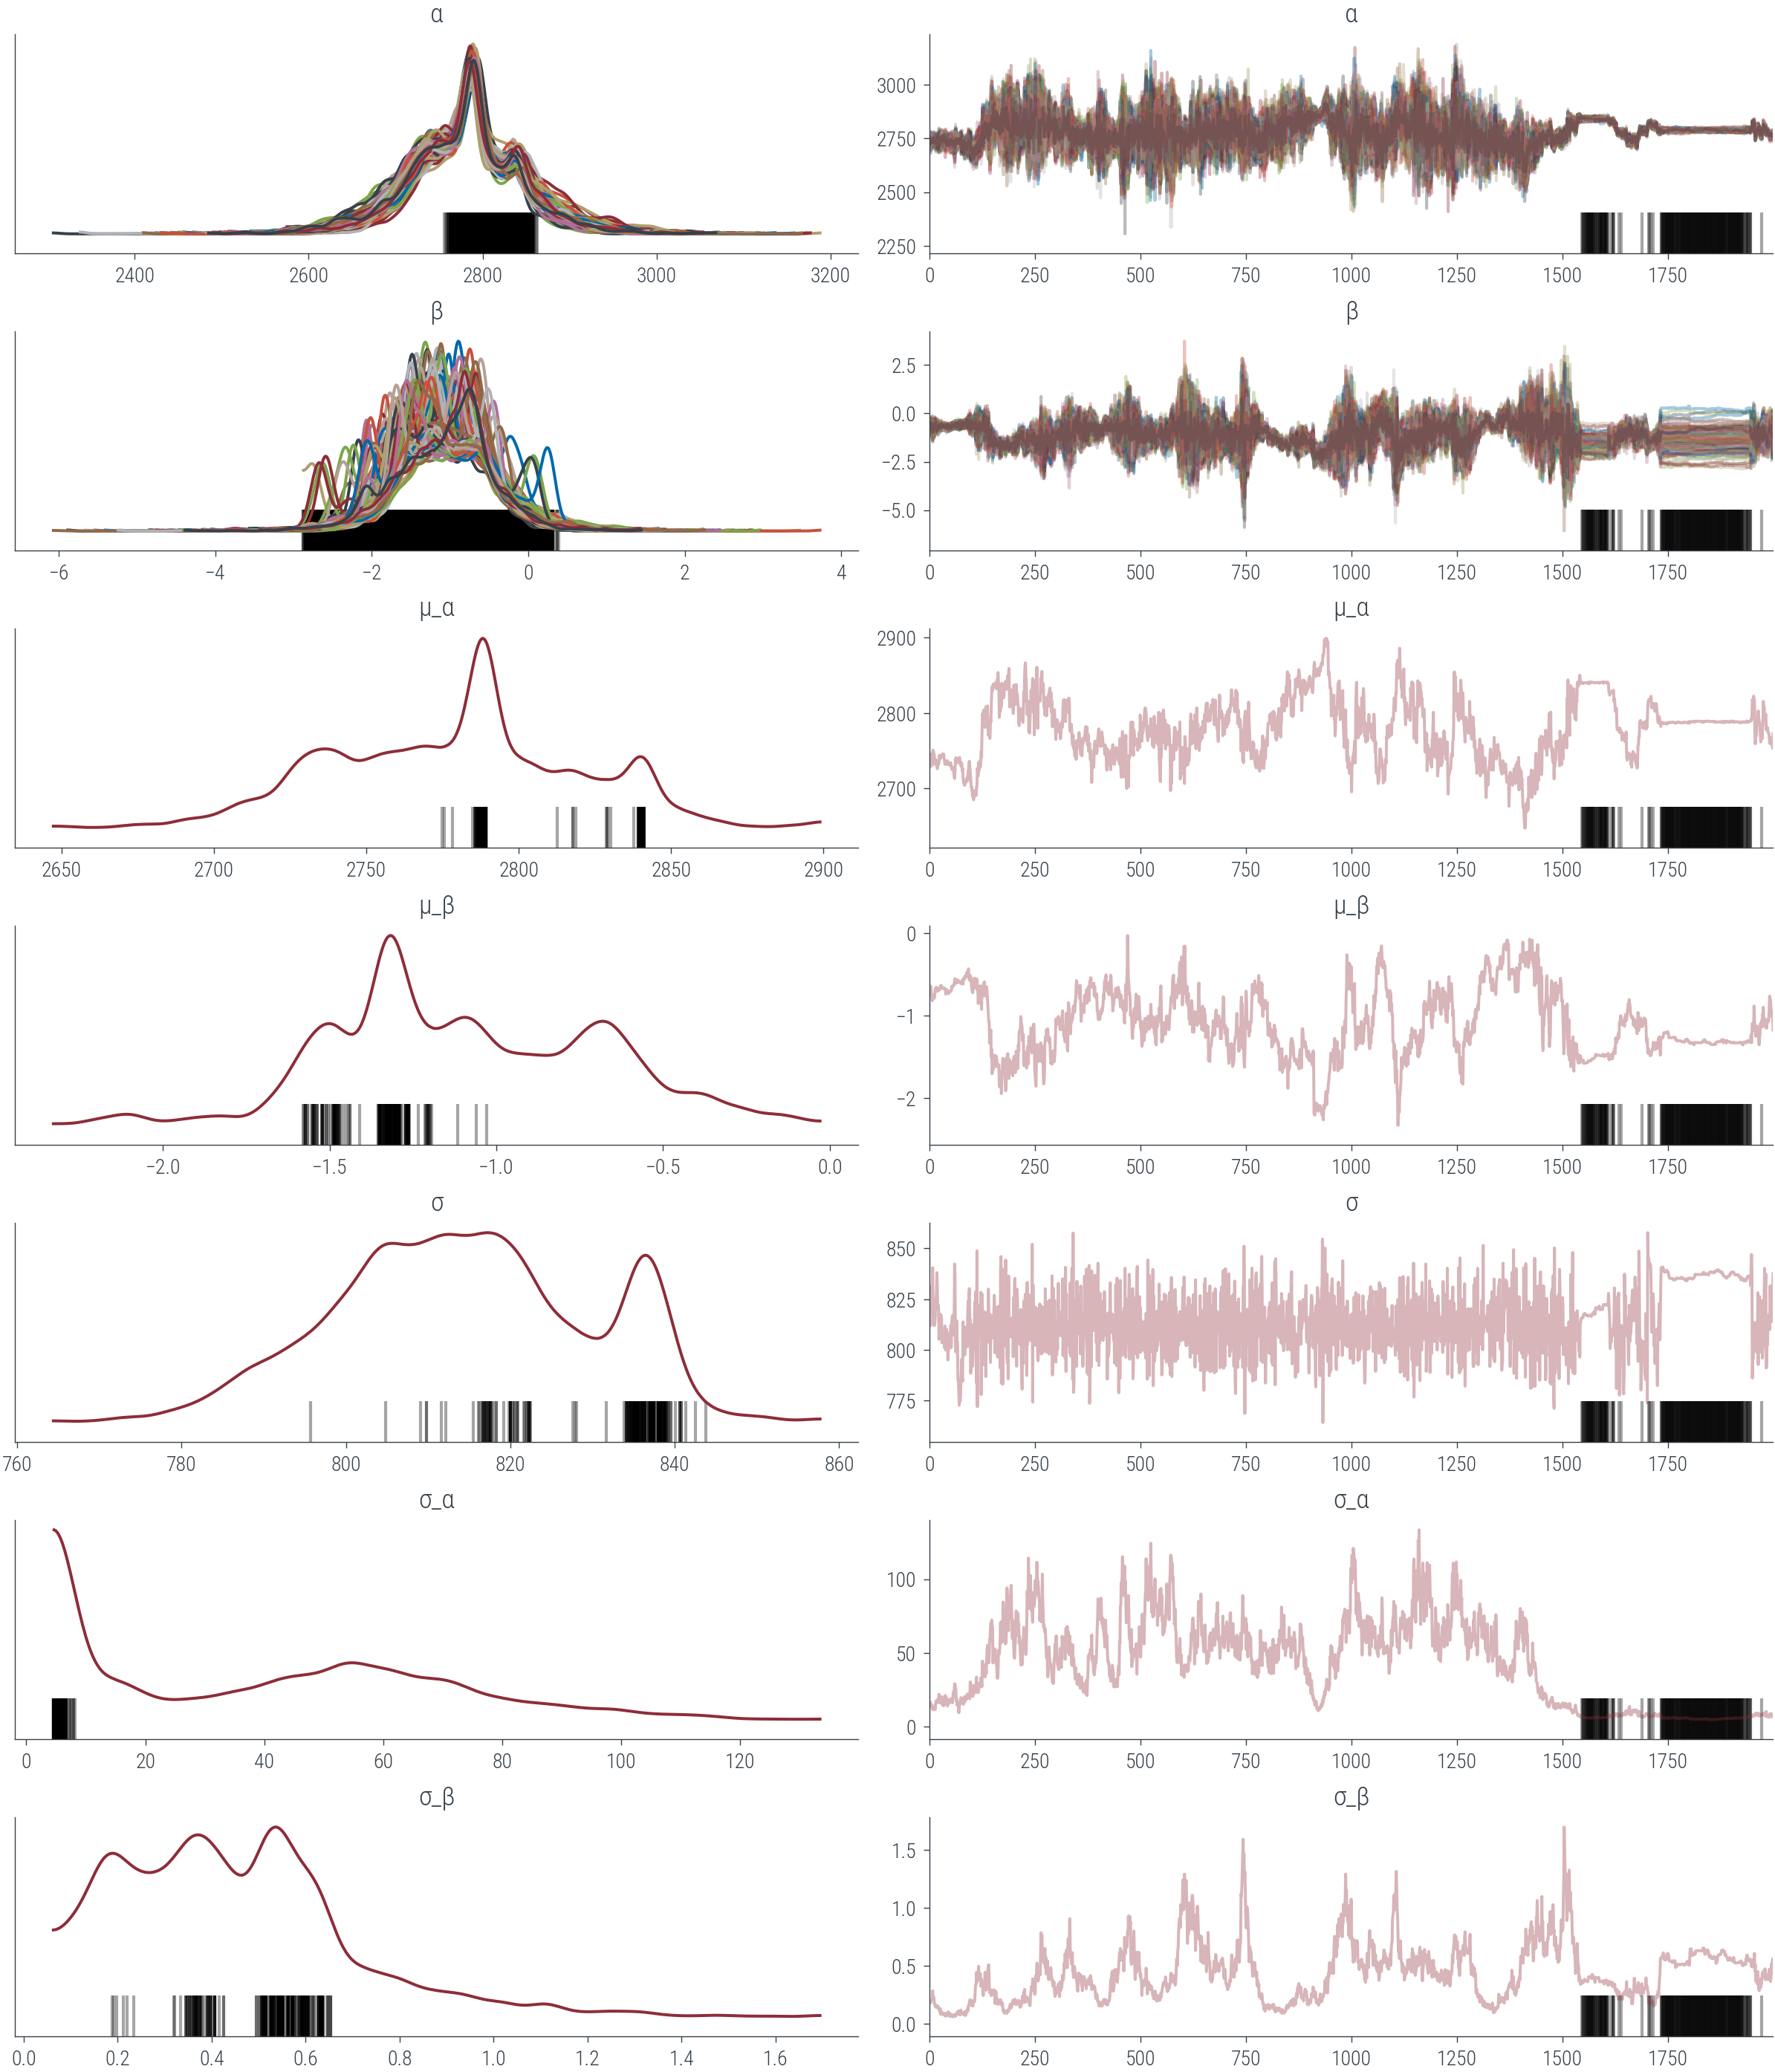

In [84]:
az.plot_trace(az.from_numpyro(mcmc_final), compact=True);

In [80]:
# Predict for a given patient


def predict_final(patient_code):
    predictions = predictive_final(rng_key, all_weeks, patient_code)
    mu = predictions["obs"].mean(axis=0)
    sigma = predictions["obs"].std(axis=0)
    return mu, sigma

# Plot the predictions for a given patient
def plot_patient_final(patient_code):
    mu, sigma = predict_final(patient_code)
    plt.plot(all_weeks, mu)
    plt.fill_between(all_weeks, mu - sigma, mu + sigma, alpha=0.1)
    id_to_patient = patient_encoder.inverse_transform([patient_code])[0]
    #print(id_to_patient[0], patient_code)
    #print(patient_code, id_to_patient)
    patient_weeks = train[train["Patient"] == id_to_patient]["Weeks"]
    patient_fvc = train[train["Patient"] == id_to_patient]["FVC"]
    plt.scatter(patient_weeks, patient_fvc, alpha=0.5)
    #plt.scatter(sample_weeks[train["patient_code"] == patient_code.item()], fvc[train["patient_code"] == patient_code.item()], alpha=0.5)
    plt.xlabel("Weeks")
    plt.ylabel("FVC")
    plt.title(patient_encoder.inverse_transform([patient_code])[0])

/home/nipun.batra/miniforge3/envs/nipun-jaxenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nipun.batra/miniforge3/envs/nipun-jaxenv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


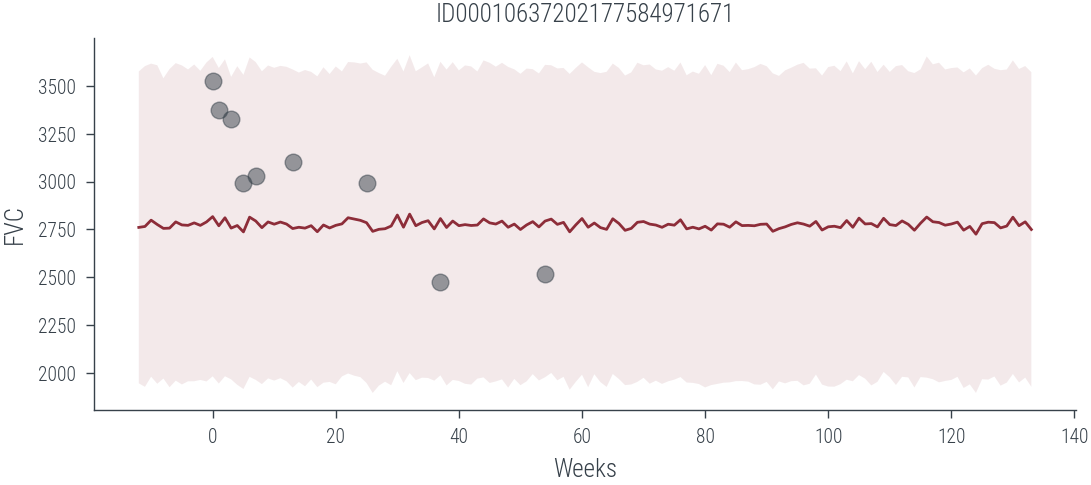

In [83]:
# plot for a given patient
plot_patient_final(np.array([2]))